In [43]:
#Import packages
import numpy as np
import pandas as pd
from pmdarima import auto_arima

In [44]:
#Read files
features = pd.read_csv("features.csv", parse_dates=['Date'])
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train_all.csv", parse_dates=['Date'])
test = pd.read_csv("test.csv", parse_dates=['Date'])

In [45]:
#Take a look at the dataframe
train.head(5)

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [46]:
#Drop unused columns
train=train.drop(['Unnamed: 0','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis='columns')

In [47]:
#Set date as index
train.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

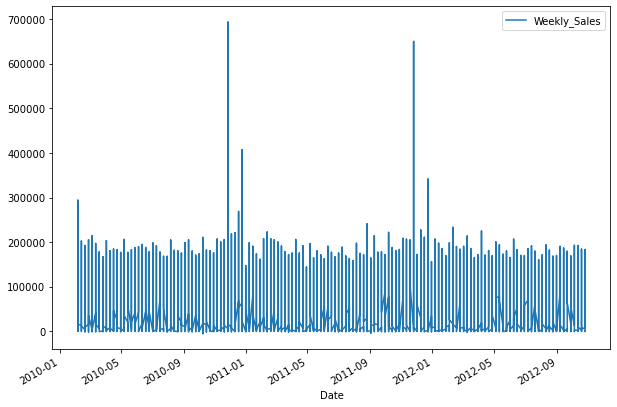

In [49]:
#Plotting 
train["Weekly_Sales"].plot(figsize = (10, 7), legend = True)

In [56]:
#Create a new dataframe to save predictions
df= pd.DataFrame(columns=['Store','Date','Predictions'])
df

,Store,Date,Predictions


In [57]:
#Build a loop to fit the model and get the predictions for each store (45 store in total)

for i in range(1,46):
    S=train[train["Store"]==i]
    S.groupby('Date').size()
    S_df=S.drop(['Store','Dept','Type','Size'],axis='columns')
    S_df['IsHoliday']= S_df["IsHoliday"].astype(int)
    S_train=S_df.groupby('Date').agg(
        Weekly_Sales=('Weekly_Sales','sum'),
        IsHoliday=('IsHoliday','min'),
        Temperature=('Temperature',np.mean),
        Fuel_Price=("Fuel_Price",np.mean),
        CPI=('CPI',np.mean),
        Unemployment=('Unemployment',np.mean)
                    )
    #Split Train/Test
    test_days = 30
    training_set = S_train.iloc[:-test_days, :]
    test_set = S_train.iloc[-test_days:, :]
    
    ##Forecasting
    
    #Exogenous variables
    train_exog = training_set.iloc[:,1:]
    test_exog = test_set.iloc[:,1:]
    
    #Fit the model
    model = auto_arima(y = training_set['Weekly_Sales'],
                   X = train_exog,
                   m = 52,
                   seasonal = True,
                   stepwise = False)
    #Predictions
    predictions_sarimax = pd.Series(model.predict(n_periods= test_days,
                              X = test_exog)).rename("Predictions")
    predictions_sarimax.index = test_set.index  
    sarimax_df=predictions_sarimax.to_frame()
    sarimax_df=sarimax_df.reset_index()
    sarimax_df['Store']=i
    #Append the predictions to the dataframe
    df=df.append(sarimax_df)


In [58]:
#Reviewing the final predictions
df

,Store,Date,Predictions
0,1,2012-04-06,1.649816e+06
1,1,2012-04-13,1.625669e+06
2,1,2012-04-20,1.583629e+06
3,1,2012-04-27,1.570538e+06
4,1,2012-05-04,1.608160e+06
...,...,...,...
25,45,2012-09-28,7.516346e+05
26,45,2012-10-05,7.733753e+05
27,45,2012-10-12,7.779095e+05
28,45,2012-10-19,8.016345e+05


In [69]:
#Create a new dataframe to save actual sales
df_test=pd.DataFrame(columns=['Store','Date','Weekly_Sales'])
df_test

,Store,Date,Weekly_Sales


In [70]:
#Build a loop to get the actual sales for each store (45 store in total)
for i in range(1,46):
    S=train[train["Store"]==i]
    S.groupby('Date').size()
    S_df=S.drop(['Store','Dept','Type','Size'],axis='columns')
    S_df['IsHoliday']= S_df["IsHoliday"].astype(int)
    S_train=S_df.groupby('Date').agg(
        Weekly_Sales=('Weekly_Sales','sum'),
        IsHoliday=('IsHoliday','min'),
        Temperature=('Temperature',np.mean),
        Fuel_Price=("Fuel_Price",np.mean),
        CPI=('CPI',np.mean),
        Unemployment=('Unemployment',np.mean)
                    )
    #Train/Test
    test_days = 30
    test_set = S_train.iloc[-test_days:, :]
    test_set=test_set.drop(['IsHoliday','Temperature','Fuel_Price','CPI','Unemployment'],axis='columns')
    test_set=test_set.reset_index()
    test_set['Store']=i
    #Append the actual sales to the dataframe
    df_test=df_test.append(test_set)

In [71]:
df_test

,Store,Date,Weekly_Sales
0,1,2012-04-06,1899676.88
1,1,2012-04-13,1621031.70
2,1,2012-04-20,1521577.87
3,1,2012-04-27,1468928.37
4,1,2012-05-04,1684519.99
...,...,...,...
25,45,2012-09-28,713173.95
26,45,2012-10-05,733455.07
27,45,2012-10-12,734464.36
28,45,2012-10-19,718125.53


In [72]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE(df_test['Weekly_Sales'], df['Predictions'])

5.740896538061921